In [2]:
#combined
#vaccination_22 data

In [3]:
import pandas as pd


In [4]:
df1 = pd.read_excel(r'C:\Users\sharm\Documents\My Folder\Project_SARS\Variant.xlsx')
df2 = pd.read_excel(r'C:\Users\sharm\Documents\My Folder\Project_SARS\Vaccination_24.xlsx')

In [5]:
df1.head()

,Country,Attribute,Value,Variant
0,Afghanistan,2019-12-29,0,Alpha
1,Albania,2019-12-29,0,Alpha
2,Algeria,2019-12-29,0,Alpha
3,American Samoa,2019-12-29,0,Alpha
4,Andorra,2019-12-29,0,Alpha


In [6]:
# Convert the 'Attribute' column to a datetime object
df1['Attribute'] = pd.to_datetime(df1['Attribute'])

# Extract month and year from the 'Attribute' column
df1['Month'] = df1['Attribute'].dt.month
df1['Year'] = df1['Attribute'].dt.year

# Group by 'Year', 'Month', and 'Variant' and sum the 'Value' column
monthly_sum_df = df1.groupby(['Year', 'Month', 'Variant','Country'])['Value'].sum().reset_index()

monthly_sum_df.head()

,Year,Month,Variant,Country,Value
0,2019,12,Alpha,Afghanistan,0
1,2019,12,Alpha,Albania,0
2,2019,12,Alpha,Algeria,0
3,2019,12,Alpha,American Samoa,0
4,2019,12,Alpha,Andorra,0


In [7]:
monthly_sum_df.rename(columns={'Country': 'location'}, inplace=True)

In [8]:
df2.head()

,location,date,daily_vaccinations
0,Norway,2020-12-02,0
1,Norway,2020-12-03,1
2,Latvia,2020-12-04,0
3,Norway,2020-12-04,1
4,Latvia,2020-12-05,0


In [9]:
# Convert the 'Attribute' column to a datetime object
df2['date'] = pd.to_datetime(df2['date'])

# Extract month and year from the 'Attribute' column
df2['Month'] = df2['date'].dt.month
df2['Year'] = df2['date'].dt.year

# Group by 'Year', 'Month', and 'Variant' and sum the 'Value' column
monthly_sum_df1 = df2.groupby(['Year', 'Month', 'location'])['daily_vaccinations'].sum().reset_index()

monthly_sum_df1.head()

,Year,Month,location,daily_vaccinations
0,2020,12,Argentina,31555
1,2020,12,Bahrain,34657
2,2020,12,Belarus,1209
3,2020,12,Belgium,534
4,2020,12,Bulgaria,4366


In [10]:
# Merge the two DataFrames based on 'Year', 'Month', and 'Location'
merged_df = pd.merge(monthly_sum_df, monthly_sum_df1, on=['Year', 'Month', 'location'])

# Select the columns you want to include in the final DataFrame
merged_df = merged_df[['Year', 'Month', 'location', 'Variant','Value', 'daily_vaccinations']]

# Print the resulting DataFrame
merged_df.head()


,Year,Month,location,Variant,Value,daily_vaccinations
0,2020,12,Argentina,Alpha,1,31555
1,2020,12,Bahrain,Alpha,0,34657
2,2020,12,Belarus,Alpha,0,1209
3,2020,12,Belgium,Alpha,18,534
4,2020,12,Bulgaria,Alpha,2,4366


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (1) Create a datetime column
# ------------------------------
merged_df['date'] = pd.to_datetime(
    merged_df[['Year','Month']].assign(DAY=1)
)

# ------------------------------
# (2) Filter for a single Location & Variant
#     (example: United States, Delta)
# ------------------------------
location_filter = 'United States'
variant_filter = 'Delta'

us_delta_df = merged_df[
    (merged_df['location'] == location_filter) & 
    (merged_df['Variant'] == variant_filter)
].copy()

# Sort by date to ensure chronological order
us_delta_df.sort_values('date', inplace=True)

# ------------------------------
# (3) Perform a time-lag analysis
#     We'll shift daily_vaccinations by 1, 2, and 3 "months" (rows)
# ------------------------------
# Original
us_delta_df['vaccinations_lag0'] = us_delta_df['daily_vaccinations']
# 1-month lag
us_delta_df['vaccinations_lag1'] = us_delta_df['daily_vaccinations'].shift(1)
# 2-month lag
us_delta_df['vaccinations_lag2'] = us_delta_df['daily_vaccinations'].shift(2)
# 3-month lag
us_delta_df['vaccinations_lag3'] = us_delta_df['daily_vaccinations'].shift(3)

# We'll drop any rows that became NaN due to shifting (the first 1-3 rows)
us_delta_df.dropna(subset=['vaccinations_lag1','vaccinations_lag2','vaccinations_lag3'],
                   inplace=True)

# For clarity, let's rename the 'Value' column to something more descriptive
# e.g., 'variant_counts'
us_delta_df.rename(columns={'Value': 'variant_counts'}, inplace=True)

# ------------------------------
# (3a) Calculate correlations
# ------------------------------
corr_lag0 = us_delta_df['variant_counts'].corr(us_delta_df['vaccinations_lag0'])
corr_lag1 = us_delta_df['variant_counts'].corr(us_delta_df['vaccinations_lag1'])
corr_lag2 = us_delta_df['variant_counts'].corr(us_delta_df['vaccinations_lag2'])
corr_lag3 = us_delta_df['variant_counts'].corr(us_delta_df['vaccinations_lag3'])

print(f"Correlation (no lag):     {corr_lag0:.3f}")
print(f"Correlation (1-month):   {corr_lag1:.3f}")
print(f"Correlation (2-month):   {corr_lag2:.3f}")
print(f"Correlation (3-month):   {corr_lag3:.3f}")




Correlation (no lag):     0.165
Correlation (1-month):   0.030
Correlation (2-month):   0.033
Correlation (3-month):   0.253


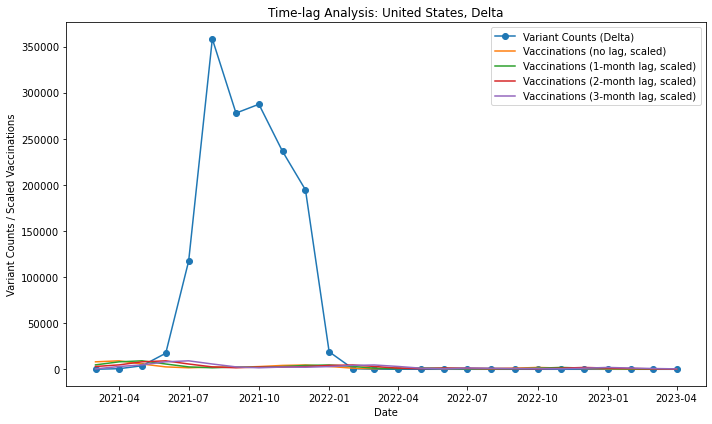

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (3b) Plot to visualize
# ------------------------------
plt.figure(figsize=(10,6))

# Convert to NumPy arrays to avoid multi-dimensional indexing issues
dates = us_delta_df['date'].to_numpy()
variant_counts = us_delta_df['variant_counts'].to_numpy()

vacc_no_lag = (us_delta_df['vaccinations_lag0']/10000).to_numpy()
vacc_lag1   = (us_delta_df['vaccinations_lag1']/10000).to_numpy()
vacc_lag2   = (us_delta_df['vaccinations_lag2']/10000).to_numpy()
vacc_lag3   = (us_delta_df['vaccinations_lag3']/10000).to_numpy()

plt.plot(dates, variant_counts, 
         marker='o', label='Variant Counts (Delta)')

plt.plot(dates, vacc_no_lag,  label='Vaccinations (no lag, scaled)')
plt.plot(dates, vacc_lag1,    label='Vaccinations (1-month lag, scaled)')
plt.plot(dates, vacc_lag2,    label='Vaccinations (2-month lag, scaled)')
plt.plot(dates, vacc_lag3,    label='Vaccinations (3-month lag, scaled)')

plt.title(f"Time-lag Analysis: {location_filter}, {variant_filter}")
plt.xlabel("Date")
plt.ylabel("Variant Counts / Scaled Vaccinations")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (1) Create a datetime column
# ------------------------------
merged_df['date'] = pd.to_datetime(
    merged_df[['Year','Month']].assign(DAY=1)
)

# ------------------------------
# (2) Filter for a single Location & Variant
#     (example: United States, Delta)
# ------------------------------
location_filter = 'India'
variant_filter = 'Delta'

ind_delta_df = merged_df[
    (merged_df['location'] == location_filter) & 
    (merged_df['Variant'] == variant_filter)
].copy()

# Sort by date to ensure chronological order
ind_delta_df.sort_values('date', inplace=True)

# ------------------------------
# (3) Perform a time-lag analysis
#     We'll shift daily_vaccinations by 1, 2, and 3 "months" (rows)
# ------------------------------
# Original
ind_delta_df['vaccinations_lag0'] = ind_delta_df['daily_vaccinations']
# 1-month lag
ind_delta_df['vaccinations_lag1'] = ind_delta_df['daily_vaccinations'].shift(1)
# 2-month lag
ind_delta_df['vaccinations_lag2'] = ind_delta_df['daily_vaccinations'].shift(2)
# 3-month lag
ind_delta_df['vaccinations_lag3'] = ind_delta_df['daily_vaccinations'].shift(3)

# We'll drop any rows that became NaN due to shifting (the first 1-3 rows)
ind_delta_df.dropna(subset=['vaccinations_lag1','vaccinations_lag2','vaccinations_lag3'],
                   inplace=True)

# For clarity, let's rename the 'Value' column to something more descriptive
# e.g., 'variant_counts'
ind_delta_df.rename(columns={'Value': 'variant_counts'}, inplace=True)

# ------------------------------
# (3a) Calculate correlations
# ------------------------------
corr_lag0 = ind_delta_df['variant_counts'].corr(ind_delta_df['vaccinations_lag0'])
corr_lag1 = ind_delta_df['variant_counts'].corr(ind_delta_df['vaccinations_lag1'])
corr_lag2 = ind_delta_df['variant_counts'].corr(ind_delta_df['vaccinations_lag2'])
corr_lag3 = ind_delta_df['variant_counts'].corr(ind_delta_df['vaccinations_lag3'])

print(f"Correlation (no lag):     {corr_lag0:.3f}")
print(f"Correlation (1-month):   {corr_lag1:.3f}")
print(f"Correlation (2-month):   {corr_lag2:.3f}")
print(f"Correlation (3-month):   {corr_lag3:.3f}")




Correlation (no lag):     0.739
Correlation (1-month):   0.641
Correlation (2-month):   0.477
Correlation (3-month):   0.328


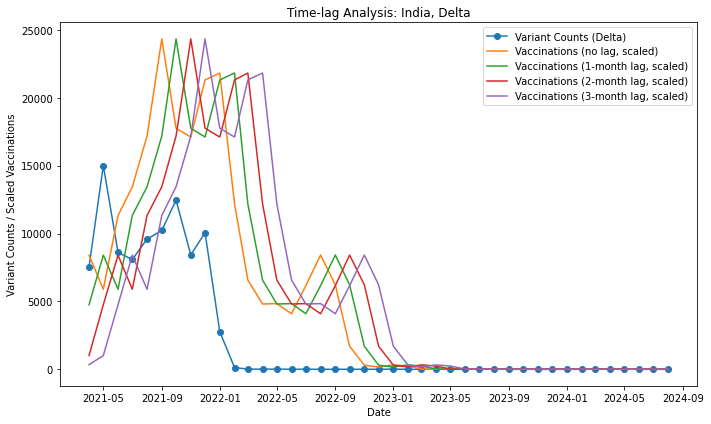

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (3b) Plot to visualize
# ------------------------------
plt.figure(figsize=(10,6))

# Convert to NumPy arrays to avoid multi-dimensional indexing issues
dates = ind_delta_df['date'].to_numpy()
variant_counts = ind_delta_df['variant_counts'].to_numpy()

vacc_no_lag = (ind_delta_df['vaccinations_lag0']/10000).to_numpy()
vacc_lag1   = (ind_delta_df['vaccinations_lag1']/10000).to_numpy()
vacc_lag2   = (ind_delta_df['vaccinations_lag2']/10000).to_numpy()
vacc_lag3   = (ind_delta_df['vaccinations_lag3']/10000).to_numpy()

plt.plot(dates, variant_counts, 
         marker='o', label='Variant Counts (Delta)')

plt.plot(dates, vacc_no_lag,  label='Vaccinations (no lag, scaled)')
plt.plot(dates, vacc_lag1,    label='Vaccinations (1-month lag, scaled)')
plt.plot(dates, vacc_lag2,    label='Vaccinations (2-month lag, scaled)')
plt.plot(dates, vacc_lag3,    label='Vaccinations (3-month lag, scaled)')

plt.title(f"Time-lag Analysis: {location_filter}, {variant_filter}")
plt.xlabel("Date")
plt.ylabel("Variant Counts / Scaled Vaccinations")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (1) Create a datetime column
# ------------------------------
merged_df['date'] = pd.to_datetime(
    merged_df[['Year','Month']].assign(DAY=1)
)

# ------------------------------
# (2) Filter for a single Location & Variant
#     (example: United States, Delta)
# ------------------------------
location_filter = 'India'
variant_filter = 'Omicron'

ind_omicron_df = merged_df[
    (merged_df['location'] == location_filter) & 
    (merged_df['Variant'] == variant_filter)
].copy()

# Sort by date to ensure chronological order
ind_omicron_df.sort_values('date', inplace=True)

# ------------------------------
# (3) Perform a time-lag analysis
#     We'll shift daily_vaccinations by 1, 2, and 3 "months" (rows)
# ------------------------------
# Original
ind_omicron_df['vaccinations_lag0'] = ind_omicron_df['daily_vaccinations']
# 1-month lag
ind_omicron_df['vaccinations_lag1'] = ind_omicron_df['daily_vaccinations'].shift(1)
# 2-month lag
ind_omicron_df['vaccinations_lag2'] = ind_omicron_df['daily_vaccinations'].shift(2)
# 3-month lag
ind_omicron_df['vaccinations_lag3'] = ind_omicron_df['daily_vaccinations'].shift(3)

# We'll drop any rows that became NaN due to shifting (the first 1-3 rows)
ind_omicron_df.dropna(subset=['vaccinations_lag1','vaccinations_lag2','vaccinations_lag3'],
                   inplace=True)

# For clarity, let's rename the 'Value' column to something more descriptive
# e.g., 'variant_counts'
ind_omicron_df.rename(columns={'Value': 'variant_counts'}, inplace=True)

# ------------------------------
# (3a) Calculate correlations
# ------------------------------
corr_lag0 = ind_omicron_df['variant_counts'].corr(ind_omicron_df['vaccinations_lag0'])
corr_lag1 = ind_omicron_df['variant_counts'].corr(ind_omicron_df['vaccinations_lag1'])
corr_lag2 = ind_omicron_df['variant_counts'].corr(ind_omicron_df['vaccinations_lag2'])
corr_lag3 = ind_omicron_df['variant_counts'].corr(ind_omicron_df['vaccinations_lag3'])

print(f"Correlation (no lag):     {corr_lag0:.3f}")
print(f"Correlation (1-month):   {corr_lag1:.3f}")
print(f"Correlation (2-month):   {corr_lag2:.3f}")
print(f"Correlation (3-month):   {corr_lag3:.3f}")

Correlation (no lag):     0.391
Correlation (1-month):   0.484
Correlation (2-month):   0.429
Correlation (3-month):   0.430


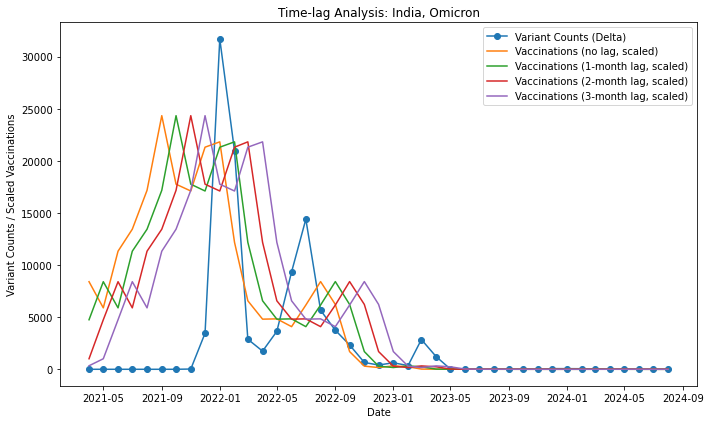

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# (3b) Plot to visualize
# ------------------------------
plt.figure(figsize=(10,6))

# Convert to NumPy arrays to avoid multi-dimensional indexing issues
dates = ind_omicron_df['date'].to_numpy()
variant_counts = china_delta_df['variant_counts'].to_numpy()

vacc_no_lag = (ind_omicron_df['vaccinations_lag0']/10000).to_numpy()
vacc_lag1   = (ind_omicron_df['vaccinations_lag1']/10000).to_numpy()
vacc_lag2   = (ind_omicron_df['vaccinations_lag2']/10000).to_numpy()
vacc_lag3   = (ind_omicron_df['vaccinations_lag3']/10000).to_numpy()

plt.plot(dates, variant_counts, 
         marker='o', label='Variant Counts (Delta)')

plt.plot(dates, vacc_no_lag,  label='Vaccinations (no lag, scaled)')
plt.plot(dates, vacc_lag1,    label='Vaccinations (1-month lag, scaled)')
plt.plot(dates, vacc_lag2,    label='Vaccinations (2-month lag, scaled)')
plt.plot(dates, vacc_lag3,    label='Vaccinations (3-month lag, scaled)')

plt.title(f"Time-lag Analysis: {location_filter}, {variant_filter}")
plt.xlabel("Date")
plt.ylabel("Variant Counts / Scaled Vaccinations")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
output_excel_file = 'merged_data.xlsx'

# Save the DataFrame to the Excel file
merged_df.to_excel(output_excel_file, index=False)

C:\Users\sharm\AppData\Local\Temp\ipykernel_23740\4285769870.py:4: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  merged_df.to_excel(output_excel_file, index=False)
